# NER with Conditional Random Fields
This notebook is heavily inspired by the work of ***Vasco Ribeiro*** as well as
- the `sklearn-crfsuite` [tutorial](https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html) on Named Entity Recognition (NER),
- a related NER tutorial using [eli5](https://eli5.readthedocs.io/en/latest/tutorials/sklearn_crfsuite.html),
- and [`scikit-learn`](https://scikit-learn.org/0.23/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV).

Import libraries and inspect the data in the *annotations.jsonl* file.

In [1]:
%matplotlib inline
import sklearn
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from utils import metrics as mtx
import scipy.stats
import random
import json

with open("../annotations.jsonl") as jsonl_file:
    lines = jsonl_file.readlines()
annot = [json.loads(line) for line in lines]
print("instances:\n{}".format(len(annot)))
keys = [key for key in annot[0].keys()]
print("\nall keys:\n{}".format(keys))
key_keys = ["text", "spans", "tokens"]
print("\nimportant keys:\n{}".format(key_keys))
print("\nexample text:\n{}".format(annot[0]["text"]))
n_examples = 5
print("\n{} example spans:".format(n_examples))
for span in annot[0]["spans"][:n_examples]:
    print("{}".format(span))
print("\n{} example tokens:".format(n_examples))
for token in annot[0]["tokens"][:n_examples]:
    print("{}".format(token))

instances:
140

all keys:
['text', 'meta', '_input_hash', '_task_hash', 'spans', 'tokens', '_view_id', 'answer', '_timestamp']

important keys:
['text', 'spans', 'tokens']

example text:
DORNBIRN In der Schulgasse in Dornbirn hat eine 71,93 Quadratmeter große Wohnung für einen Quadratmeterpreis von 5533,71 Euro den Besitzer gewechselt. Dieser beinhaltet auch einen Pkw-Abstellplatz. Käufer der Wohnung mit 9,86 Quadratmetern Terrasse ist die ValLiLean Beteiligungs- und Immobilienverwaltungs GmbH. Beim Verkäufer handelt es sich um die Karrenblick Projekt GmbH.  Der Kaufpreis liegt bei 398.040 Euro. Unterzeichnet wurde der Kaufvertrag am 18. September. Die Verbücherung datiert mit Oktober 2020.

5 example spans:
{'text': 'DORNBIRN', 'start': 0, 'end': 8, 'pattern': 2069086582, 'token_start': 0, 'token_end': 0, 'label': 'ORT'}
{'start': 16, 'end': 26, 'token_start': 3, 'token_end': 3, 'label': 'STRASSE'}
{'text': 'Dornbirn', 'start': 30, 'end': 38, 'pattern': 2069086582, 'token_start': 5, '

There are 140 instances of real estate offerings. Each instance is represented in the form of a dictionary with keys. Important keys are
- `text`, with the original text as value,
- `spans`, with a list of dictionaries as values, where each dictionary represents an annotation obtained via [prodigy](https://prodi.gy/), and
- `tokens`, again with a list of dictionaries as values, but now, every dictionary represents a token.

The above output shows an example.

## Data Preprocessing
Given a list of span dictionaries (key `spans`) and an index referring to the text position within the real estate offering text, return the prodigy label.

In [2]:
def getLabel(tokenDictList, idx):
    result = "O"
    for dict_i in tokenDictList:
        idx_0, idx_1 = dict_i['start'], dict_i['end']
        if (idx_0<=idx) and (idx<=idx_1):
            result = dict_i["label"]
    return result 

myDictList = [
    {'start':0, 'end':3, 'label': 'ORT'},
    {'start':5, 'end':8, 'label': 'ORT2'},
    {'start':10, 'end':13, 'label': 'ORT3'}
]

for i in range(16):
    pos = i-1
    print("label for position {}:\t{}".format(pos, getLabel(myDictList, i-1)))

label for position -1:	O
label for position 0:	ORT
label for position 1:	ORT
label for position 2:	ORT
label for position 3:	ORT
label for position 4:	O
label for position 5:	ORT2
label for position 6:	ORT2
label for position 7:	ORT2
label for position 8:	ORT2
label for position 9:	O
label for position 10:	ORT3
label for position 11:	ORT3
label for position 12:	ORT3
label for position 13:	ORT3
label for position 14:	O


Enhance the `tokens` dictionaries by labels. The labels are stored in the `spans` dictionaries. Unless the trivial class, *O* is assigned to a token, a prepending *I-* (*B-*) denotes the token to be the initial (a subsequent) one in the labelled expression.

In [3]:
#for j in range(len(annot)): # loop over instances
#    a = annot[j]            # instance j
#    spans = a['spans']      # list of annotation dicts
#    toks = a['tokens']      # list of token dicts
#    for i in range(len(toks)):                                 # loop over token dicts
#        toks[i]['label'] = getLabel(spans, toks[i]['start'])   # assign label from span (if exists, otherwise "O")
#        if toks[i]['label'] != "O":                            # if the token represents an entity ...
#            if i==0:
#                toks[i]['label'] = "B-"+toks[i]['label']       # ... and is the first in the text => "B-" + label
#            else:                                              # not first token in text:
#                if (toks[i]['label']==toks[i-1]['label'][2:]):
#                    toks[i]['label'] = "I-"+toks[i]['label']   # > but same label as previous token => "I-" + label
#                else:
#                    toks[i]['label'] = "B-"+toks[i]['label']   # > but first token of an entity => "B-" + label
#    annot[j]['tokens'] = toks

# avoid leading B- and I-
for j in range(len(annot)): # loop over instances
    a = annot[j]            # instance j
    spans = a['spans']      # list of annotation dicts
    toks = a['tokens']      # list of token dicts
    for i in range(len(toks)):                                 # loop over token dicts
        toks[i]['label'] = getLabel(spans, toks[i]['start'])   # assign label from span (if exists, otherwise "O")
        if toks[i]['label'] != "O":                            # if the token represents an entity ...
            if i==0:
                toks[i]['label'] = ""+toks[i]['label']         # ... and is the first in the text => "B-" + label
            else:                                              # not first token in text:
                if (toks[i]['label']==toks[i-1]['label'][2:]):
                    toks[i]['label'] = ""+toks[i]['label']    # > but same label as previous token => "I-" + label
                else:
                    toks[i]['label'] = ""+toks[i]['label']    # > but first token of an entity => "B-" + label
    annot[j]['tokens'] = toks

words_n = 3
for i in range(2):
    print("Token dictionaries for the last {} words of instance {}".format(words_n, i))
    ann = annot[i]
    for tok in ann["tokens"][:words_n]:
        print(tok)
# O => trivial class (no entity)
# B => Entity or leading token of an entity
# I => subsequent token of an entity

Token dictionaries for the last 3 words of instance 0
{'text': 'DORNBIRN', 'start': 0, 'end': 8, 'id': 0, 'ws': True, 'label': 'ORT'}
{'text': 'In', 'start': 9, 'end': 11, 'id': 1, 'ws': True, 'label': 'O'}
{'text': 'der', 'start': 12, 'end': 15, 'id': 2, 'ws': True, 'label': 'O'}
Token dictionaries for the last 3 words of instance 1
{'text': 'FELDKIRCH', 'start': 0, 'end': 9, 'id': 0, 'ws': True, 'label': 'ORT'}
{'text': 'Im', 'start': 10, 'end': 12, 'id': 1, 'ws': True, 'label': 'O'}
{'text': 'Altenreuteweg', 'start': 13, 'end': 26, 'id': 2, 'ws': True, 'label': 'STRASSE'}


Use the enhanced list of *token* dictionaries to create a list where each instance is represented by a list of *(token, label)* pairs.

In [4]:
sents=[] 
for annot_i in annot:                  # loop over instances
    toks = annot_i['tokens']           # get tokens list for instance i
    train_sentence = []
    for tok in toks:                   # loop over token dicts
        if 'label' in tok:             # only if the current token has been labelled, ...
            token_element = (tok['text'], tok['label']) # ... create a "text", "label" pair for this token ...
            train_sentence.append(token_element)        # ... and append it to the list
    sents.append(train_sentence) # append the list for that instances to the list for all instances / sentences

# list of lists of pairs (sets): outer list contains instances and inner list contains (token, label) pairs
sents[:2]

[[('DORNBIRN', 'ORT'),
  ('In', 'O'),
  ('der', 'O'),
  ('Schulgasse', 'STRASSE'),
  ('in', 'O'),
  ('Dornbirn', 'ORT'),
  ('hat', 'O'),
  ('eine', 'O'),
  ('71,93', 'FLAECHE'),
  ('Quadratmeter', 'O'),
  ('große', 'O'),
  ('Wohnung', 'IMMO_TYP'),
  ('für', 'O'),
  ('einen', 'O'),
  ('Quadratmeterpreis', 'O'),
  ('von', 'O'),
  ('5533,71', 'QMPREIS'),
  ('Euro', 'O'),
  ('den', 'O'),
  ('Besitzer', 'O'),
  ('gewechselt', 'O'),
  ('.', 'O'),
  ('Dieser', 'O'),
  ('beinhaltet', 'O'),
  ('auch', 'O'),
  ('einen', 'O'),
  ('Pkw-Abstellplatz', 'O'),
  ('.', 'O'),
  ('Käufer', 'O'),
  ('der', 'O'),
  ('Wohnung', 'O'),
  ('mit', 'O'),
  ('9,86', 'TERRASSENGROESSE'),
  ('Quadratmetern', 'O'),
  ('Terrasse', 'O'),
  ('ist', 'O'),
  ('die', 'O'),
  ('ValLiLean', 'KAEUFER'),
  ('Beteiligungs-', 'KAEUFER'),
  ('und', 'KAEUFER'),
  ('Immobilienverwaltungs', 'KAEUFER'),
  ('GmbH.', 'KAEUFER'),
  ('Beim', 'O'),
  ('Verkäufer', 'O'),
  ('handelt', 'O'),
  ('es', 'O'),
  ('sich', 'O'),
  ('um', 'O'),
 

Now, turn each token into features ...

In [5]:
def word2features(sent, i): # receive instance and the index i for the i-th token of the instance
    word = sent[i][0]       # i-th token ("sent" is a list of (token, label) pairs; the label is not used, here)
    # dictionary of features for the i-th token
    features = {
        'bias': 1.0,                      # a different bias could be computed here (static 1 is useless)
        'word.lower()': word.lower(),     # token in lowercase
        'word[-3:]': word[-3:],           # last 3 letters
        'word[-2:]': word[-2:],           # last 2 letters
        'word.isupper()': word.isupper(), # True if uppercase else False
        'word.istitle()': word.istitle(), # True if title else False, see...
        # ... https://www.w3schools.com/python/trypython.asp?filename=demo_ref_string_istitle2
        'word.isdigit()': word.isdigit()  # True if digit else False
    }
    if i > 0:
        # add features for the previous token
        word_minus_1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word_minus_1.lower(),
            '-1:word.istitle()': word_minus_1.istitle(),
            '-1:word.isupper()': word_minus_1.isupper(),
        })
    else: # the beginning of the sequence
        features['BOS'] = True

    if i < len(sent)-1:
        # add features for the next token
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else: # the end of the sequence
        features['EOS'] = True

    return features


def sent2features(sent):                                      # pass list of (token, label) pairs
    return [word2features(sent, i) for i in range(len(sent))] # pass list of (token, label) pairs and the index ...
    # ... for a position in that list => obtain dict with token features => return list of such feature dicts

# obtain list of dicts with features for the corresponding tokens
len(sent2features(sents[0]))

74

... and - independently - each label into features. Use these functions to build the dataset.

In [6]:
def sent2labels(sent):   # pass one instance (=list of (token, label) pairs) => return list of labels
    return [label for token, label in sent]

X = [sent2features(s) for s in sents] # list of instances, each a list of tokens represented by a feature dict ...
                                      # ... => list of dictionaries
y = [sent2labels(s) for s in sents]   # list of instances, each a list of tokens represented by a label
print(len(X))
[print(X[0][i]) for i in range(4)]
print("")
print(len(y))
[print(y[0][i]) for i in range(4)]
print("")

140
{'bias': 1.0, 'word.lower()': 'dornbirn', 'word[-3:]': 'IRN', 'word[-2:]': 'RN', 'word.isupper()': True, 'word.istitle()': False, 'word.isdigit()': False, 'BOS': True, '+1:word.lower()': 'in', '+1:word.istitle()': True, '+1:word.isupper()': False}
{'bias': 1.0, 'word.lower()': 'in', 'word[-3:]': 'In', 'word[-2:]': 'In', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, '-1:word.lower()': 'dornbirn', '-1:word.istitle()': False, '-1:word.isupper()': True, '+1:word.lower()': 'der', '+1:word.istitle()': False, '+1:word.isupper()': False}
{'bias': 1.0, 'word.lower()': 'der', 'word[-3:]': 'der', 'word[-2:]': 'er', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, '-1:word.lower()': 'in', '-1:word.istitle()': True, '-1:word.isupper()': False, '+1:word.lower()': 'schulgasse', '+1:word.istitle()': True, '+1:word.isupper()': False}
{'bias': 1.0, 'word.lower()': 'schulgasse', 'word[-3:]': 'sse', 'word[-2:]': 'se', 'word.isupper()': False, 'word

Split the data into sets for training (3/4) and testing (1/4).

In [7]:
# Courtesy of Vasco Ribeiro
train_ratio = 0.75
train_test_split = round(0.75*len(X) - 0.5) # -0.5 => floor
idx = [i for i in range(len(X))]
print(idx[:5])
idx_shuffle = shuffle(idx,random_state=0)
print(idx_shuffle[:5])
X_shuffle, y_shuffle = [X[idx_i] for idx_i in idx_shuffle], [y[idx_i] for idx_i in idx_shuffle]
X_train, X_test = X_shuffle[:train_test_split], X_shuffle[train_test_split:]
y_train, y_test = y_shuffle[:train_test_split], y_shuffle[train_test_split:]

[0, 1, 2, 3, 4]
[45, 59, 7, 50, 92]


Use a dictionary to track the occurrence counts of the labels and show them in a sorted way. The list of labels for the test set is also required further below.

In [8]:
test_label_dict = {}
for y in y_test:
    for y_i in y:
        if y_i not in test_label_dict:
            test_label_dict[y_i] = 1
        else:
            test_label_dict[y_i] += 1

test_labels = [key for key in test_label_dict.keys()]        # dict keys to list
test_labels = sorted(test_labels, key=lambda name: name[1:]) # sort list

print("counts\t label\n")
for label in test_labels:
    label_count = 0
    if label in test_label_dict:
        label_count = test_label_dict[label]
    print("{}\t {}".format(label_count, label))

counts	 label

1362	 O
63	 KAEUFER
62	 DATUM_VERBUECHERUNG
91	 DATUM_VERTRAG
70	 VERKAEUFER
9	 TERRASSENGROESSE
28	 GESAMTPREIS
38	 FLAECHE
52	 IMMO_TYP
23	 QMPREIS
66	 ORT
44	 STRASSE


We are done with data preprocessing.

## Majority baseline
The baseline model is a basic reference model to which more sophisticated models are compared. When a model performs worse than the baseline model, something clearly went wrong. As usual with NER, most words / tokens are actually not entities, i.e., most of them belong to the default / trivial class. Thus, a basic baseline model can be obtained by having it always predict the trivial class. `MajorityBaseline` below does exactly that. 

In [9]:
class MajorityBaseline:
    """
    Naive model that simply predicts the most frequent label in the training data.
    
    attributes:
        self.dict: internal dictionary with training labels as keys and total label occurrences as values
        self.dictMax: occurrence count of the most prominent label in the training data; initialized to 0
        self.pred: value predicted by this baseline model (initialized to None and updated during training)
    
    methods:
        train: receives X_train and y_train as arguments but X_train is only passed for conformity (not
            actually required); updates self.dict, self.dictMax and self.pred
        predict: receives X as an argument and returns copies of self.pred in matching format; requires
            that self.pred is not None => train method must be called beforehand
    """
    def __init__(self):
        self.dict = {}
        self.dictMax = 0
        self.pred = None

    def train(self, X_train, y_train): # X_train included for conformity but not required
        # build dictionary: dict[label] = number of label's occurrences
        for y_i in y_train:
            for label in y_i:
                if label not in self.dict:
                    self.dict[label] = 1
                else:
                    self.dict[label] += 1
        # dictionary is built => find the most frequent label
        for label in self.dict:
            label_occurrences = self.dict[label]
            if label_occurrences > self.dictMax:
                self.dictMax = label_occurrences # update the max occurrence count of the most frequent label
                self.pred = label                # initialize / update the label that this baseline model predicts
    
    def predict(self, X):
        if self.pred == None:
            print("ERROR: MajorityBaseline has not been trained, yet!")
        else:
            instances = []
            for x_i in X:
                labels = []
                for x_ij in x_i:
                    labels.append(self.pred)
                instances.append(labels)
        return instances

Instantiate and train the model. Then make predictions and see how it performs!

In [10]:
baselineModel = MajorityBaseline()
baselineModel.train(X_train, y_train)
y_mb_test_pred = baselineModel.predict(X_test)
baseline_score = metrics.flat_f1_score(y_test, y_mb_test_pred, average='weighted')
print("Majority baseline:\t\t{}".format(baseline_score))
#print("Majority baseline seqeval:\t{}".format(mtx.f1_strict_IOB2(y_test, y_mb_test_pred)))

Majority baseline:		0.5946454330390629


So the above number is the baseline for the $F_1$ score. Hopefully, a model with Conditional Random Fields (CRF) can outperform the baseline model.

## Conditional Random Fields with Hyperparameter Search
We use the `sklearn_crfsuite` library and explore the hyperparameter space via `RandomizedSearchCV` from `scikit-learn`.

In [11]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(max_iterations=300)
params_space = {
    'algorithm': ['lbfgs', 'l2sgd', 'ap', 'pa', 'arow'],
    'c1': [1.0, 0.1, 0.01],
    'c2': [1.0, 0.1, 0.01],
    'all_possible_states': [True, False],
    'num_memories': [4,5,6,7,8],
    'epsilon': [1e-6, 1e-5, 1e-4, 1e-3,],
}
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted')
# search
## RandomizedSearchCV: 300 fits in 0.5 minutes
search = RandomizedSearchCV(crf, params_space, cv=3, verbose=1, n_jobs=-1, n_iter=100, scoring=f1_scorer) # 300 fits
## GridSearchCV: 24000 fits => 80 times 300 fits => approx. 40 minutes
#search = GridSearchCV(crf, params_space, cv=3, verbose=1, n_jobs=-1, scoring=f1_scorer) # 24000 fits
search.fit(X_train, y_train)
search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From ve

/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn_crfsuite/estimator.py", line 307, in fit
    trainer = self._get_trainer()
  File "/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn_crfsuite/estimator.py", line 530, in _get_trainer
    return trainer_cls(
  File "pycrfsuite/_pycrfsuite.pyx", line 260, in pycrfsuite._pycrfsuite.BaseTrainer.__init__
  File "pycrfsuite/_pycrfsuite.pyx", line 390, in pycrfsuite._pycrfsuite.BaseTrainer.set_params
  File "pycrfsuit

CPU times: user 2.44 s, sys: 51.1 ms, total: 2.49 s
Wall time: 21.9 s


CRF(algorithm='lbfgs', all_possible_states=False, c1=0.1, c2=0.01,
    epsilon=0.0001, keep_tempfiles=None, max_iterations=300, num_memories=7)

## Metrics
The best model has been selected and retrained on the entire training data (see the [documentation](https://scikit-learn.org/0.23/modules/generated/sklearn.model_selection.RandomizedSearchCV.html?highlight=randomizedsearchcv#sklearn.model_selection.RandomizedSearchCV) for `RandomizedSearchCV`). Performance for the $F_1$ score is shown below.

In [12]:
y_pred = search.predict(X_test)
print("Best model:\t\t{}".format(metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=test_labels)))
#print("Best model seqeval:\t{}".format(mtx.f1_strict_IOB2(y_test, y_pred)))

Best model:		0.944466915041961


Classification report below:

In [13]:
# group B and I results
sorted_test_labels = sorted(test_labels, key=lambda name: name[1:])
print(metrics.flat_classification_report(y_test, y_pred, labels=sorted_test_labels, digits=3))

                     precision    recall  f1-score   support

                  O      0.958     0.990     0.974      1362
            KAEUFER      0.734     0.746     0.740        63
DATUM_VERBUECHERUNG      1.000     0.935     0.967        62
      DATUM_VERTRAG      1.000     0.912     0.954        91
         VERKAEUFER      0.884     0.543     0.673        70
   TERRASSENGROESSE      0.900     1.000     0.947         9
        GESAMTPREIS      0.957     0.786     0.863        28
            FLAECHE      1.000     1.000     1.000        38
           IMMO_TYP      0.864     0.731     0.792        52
            QMPREIS      0.920     1.000     0.958        23
                ORT      0.971     1.000     0.985        66
            STRASSE      0.822     0.841     0.831        44

           accuracy                          0.947      1908
          macro avg      0.917     0.874     0.890      1908
       weighted avg      0.946     0.947     0.944      1908



/home/matthias/anaconda3/envs/hf20220408/lib/python3.9/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['O', 'KAEUFER', 'DATUM_VERBUECHERUNG', 'DATUM_VERTRAG', 'VERKAEUFER', 'TERRASSENGROESSE', 'GESAMTPREIS', 'FLAECHE', 'IMMO_TYP', 'QMPREIS', 'ORT', 'STRASSE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Confusion matrix below:

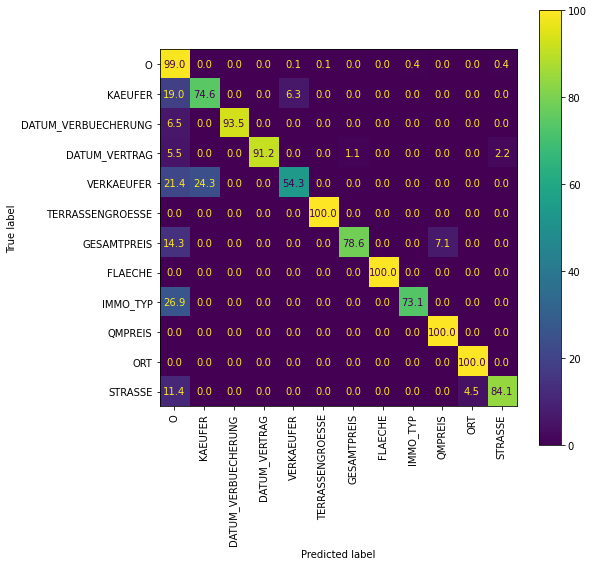

In [14]:
mtx.make_confusion_matrix(y_test, y_pred, sorted_test_labels, size=8)

$\checkmark$